# Principal Component Analysis
Principal component analysis is a technique used to pick out the primary contributions to a spectrum (well that is how I am using it) called eigenspectra. My idea is the following:
- Use PCA to decompose multi-temperature X-ray spectra
- Train a machine learning algorithm to determine the number of temperature emission profiles in a spectra

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import collections

## Training the Algorithm
Here we are training our algorithm against data with a signal-to-noise value of 150. 
- The temperature varies between 0.1-8 keV
- The metalicity varies between 0.2 - 1.0 Z_solar. With a given spectra, all thermal components have the same metallicity
- Between 1 and 4 underlying temperature components

In [2]:
data_dir = '/export/carterrhea/Documents/Pumpkin/PCA/PCA_ML/ACIS03/StN150'
syn_name = 'spec_'  # Prefix for synthetic data
syn_num = 40000  # Number of synthetic data
syn_ext = '.fits'  # Extension for synthetic data
n_components = 25  # Number of components we are interested in picking out using PCA
output_dir = '/export/carterrhea/Documents/Pumpkin/PCA/PCA_ML/ACIS03'
# Change Directories
os.chdir(data_dir)

In [3]:
# Read in Spectral Data using astropy
chan_min = 0  # Minimum value for channel
chan_max = 600  # Maximum value for channel
Counts = []
Counts_init = []
for spec_ct in tqdm(list(range(syn_num))):
    spec = fits.open(syn_name+str(spec_ct)+syn_ext)
    spec = spec[1].data
    vals = list(spec[chan_min:chan_max][:])
    channel = list(list(zip(*vals))[0])
    counts = list(list(zip(*vals))[1])
    Counts_init.append(counts)    
    # Normalize Data
    counts_max = np.max(counts)
    counts_norm = [count/counts_max for count in counts]
    Counts.append(counts_norm)

/home/carterrhea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [4]:
# Read in labels
Labels = []
with open('/export/carterrhea/Documents/Pumpkin/PCA/PCA_ML/ACIS03/tracking_stn150.txt','r') as f_lab:
    # Step through each line -> spectra
    next(f_lab)
    for line in f_lab:
        column = line.split(' ')
        # Label single vs double
        if column[-1].strip('\n') == 'single':  # single 
            Labels.append('single')
        elif column[-1].strip('\n') == 'double':
            Labels.append('double')
        elif column[-1].strip('\n') == 'triple':
            Labels.append('triple')
        elif column[-1].strip('\n') == 'quad':
            Labels.append('quad')    
            

In [5]:
# Randomly re-arrange counts/labels
reorder = list(zip(Counts, Labels))
random.shuffle(reorder)
Counts, Labels = zip(*reorder)

In [6]:
# Set training and verification sets
split_num = 36000  # Number of training to use
Training = Counts[:split_num]
Training_labels = Labels[:split_num]
Test = Counts[split_num:]
Test_labels = Labels[split_num:]

In [7]:
# Apply PCA
pca = PCA(n_components=n_components, whiten=True)
Training_proj = pca.fit_transform(np.array(Training))

In [8]:
# Train decision tree classifier
#classifier = DecisionTreeClassifier()
classifier = RandomForestClassifier(n_estimators=30,max_depth=35,criterion='entropy')  # DecisionTreeClassifier()
classifier.fit(Training_proj,Training_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=35, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

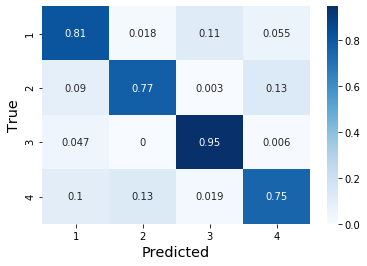

In [9]:
# Testing step 
Test_proj = pca.transform(Test)
Predicted_labels = classifier.predict(Test_proj)
# Test the predictions by making a correlation matrix
matrix_conf = confusion_matrix(Test_labels,Predicted_labels)
# Normalize confusion matrix
matrix_conf = matrix_conf.astype('float64') 
norm_fac = np.sum(matrix_conf[:], axis=1)
for row in range(matrix_conf.shape[0]):
    matrix_conf[row,:] = np.round(matrix_conf[row,:]*(1/norm_fac[row]),3)
# Plot confusion matrix    
sns_plot = sns.heatmap(matrix_conf, annot=True, cmap='Blues')
sns_plot.set(xticklabels=np.arange(1,5))
sns_plot.set(yticklabels=np.arange(1,5))
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
sns_fig = sns_plot.get_figure()
sns_fig.savefig(output_dir+'/PCA_ML_StN150_Train_ConfMat.png')

In [10]:
# Save classifier
with open(output_dir+'/ML_pred_StN150.class', 'wb') as f:
    pickle.dump(classifier, f)
# Save PCA
with open(output_dir+'/PCA_StN150.class', 'wb') as f:
    pickle.dump(pca, f)
print(sum(pca.explained_variance_ratio_))

0.9999999885131563


In [32]:
## Get probablities for each classification bin for each spectra
# classifier.predict_proba(Verification_proj)

## Without PCA

In [ ]:
# Train decision tree classifier
#classifier2 = DecisionTreeClassifier()
classifier2 = RandomForestClassifier(n_estimators=30,criterion='entropy')
classifier2.fit(Training,Training_labels)
# Verification step 
Predicted_labels = classifier2.predict(Verification)
# Test the predictions by making a correlation matrix
matrix_conf = confusion_matrix(Verification_labels,Predicted_labels)
# Normalize confusion matrix
matrix_conf = matrix_conf.astype('float64') 
norm_fac = np.sum(matrix_conf[:], axis=1)
for row in range(matrix_conf.shape[0]):
    matrix_conf[row,:] = np.round(matrix_conf[row,:]*(1/norm_fac[row]),3)
# Plot confusion matrix    
sns_plot = sns.heatmap(matrix_conf, annot=True, cmap='Blues')
sns_plot.set(xticklabels=np.arange(1,5))
sns_plot.set(yticklabels=np.arange(1,5))
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
sns_fig = sns_plot.get_figure()
sns_fig.savefig(output_dir+'/ML_ConfMat.png')

## Test on Spectra Created with Mekal Model

In [19]:
data_dir = '/export/carterrhea/Documents/Pumpkin/SpectraML/PCA_ML/StN150Mekal'
syn_name = 'spec_'  # Prefix for synthetic data
syn_num = 40000  # Number of synthetic data
syn_ext = '.fits'  # Extension for synthetic data
n_components = 25  # Number of components we are interested in picking out using PCA
# Change Directories
os.chdir(data_dir)
# Read in Spectral Data using astropy
chan_min = 0  # Minimum value for channel
chan_max = 600  # Maximum value for channel
Mekal_test = []
ct = 0
for spec_ct in tqdm(list(range(syn_num))):
    if ct%50 == 0:  # Only read in every 100 spectra
        spec = fits.open(syn_name+str(spec_ct)+syn_ext)
        spec = spec[1].data
        vals = list(spec[chan_min:chan_max][:])
        channel = list(list(zip(*vals))[0])
        counts = list(list(zip(*vals))[1])
        # Normalize Data
        counts_max = np.max(counts)
        counts_norm = [count/counts_max for count in counts]
        Mekal_test.append(counts_norm)
    ct += 1

/home/carterrhea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [20]:
# Read in labels
Mekal_Labels = []
ct = 0
with open('/export/carterrhea/Documents/Pumpkin/SpectraML/PCA_ML/tracking_stn150_mekal.txt','r') as f_lab:
    # Step through each line -> spectra
    next(f_lab)
    ct = 0
    for line in f_lab:
        if ct%50 == 0:  # Only read in every 100 spectra
            column = line.split(' ')
            # Label single vs double
            if column[-1].strip('\n') == 'single':  # single 
                Mekal_Labels.append('single')
            elif column[-1].strip('\n') == 'double':
                Mekal_Labels.append('double')
            elif column[-1].strip('\n') == 'triple':
                Mekal_Labels.append('triple')
            elif column[-1].strip('\n') == 'quad':
                Mekal_Labels.append('quad')    
        ct += 1        
            
Mekal_Labels = Mekal_Labels[0:syn_num]

In [23]:
# Randomly re-arrange counts/labels
reorder = list(zip(Mekal_test, Mekal_Labels))
random.shuffle(reorder)
Mekal_test, Mekal_Labels = zip(*reorder)


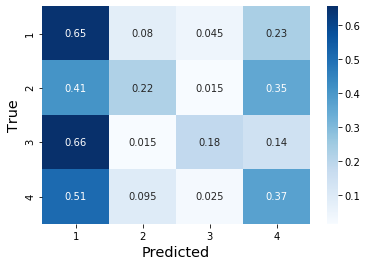

In [24]:
# Verification step 
Mekal_test_proj = pca.transform(Mekal_test)
Mekal_Predicted_labels = classifier.predict(Mekal_test_proj)
# Test the predictions by making a correlation matrix
matrix_conf = confusion_matrix(Mekal_Labels,Mekal_Predicted_labels)
# Normalize confusion matrix
matrix_conf = matrix_conf.astype('float64') 
norm_fac = np.sum(matrix_conf[:], axis=1)
for row in range(matrix_conf.shape[0]):
    matrix_conf[row,:] = np.round(matrix_conf[row,:]*(1/norm_fac[row]),3)
# Plot confusion matrix    
sns_plot = sns.heatmap(matrix_conf, annot=True, cmap='Blues')
sns_plot.set(xticklabels=np.arange(1,5))
sns_plot.set(yticklabels=np.arange(1,5))
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
sns_fig = sns_plot.get_figure()
sns_fig.savefig(output_dir+'/ConfMat_Mekal_on_Apec_StN150.png')

## Testing Against StN=50

In [26]:
data_dir = '/export/carterrhea/Documents/Pumpkin/SpectraML/PCA_ML/StN50'
output_dir = '/export/carterrhea/Documents/Pumpkin/SpectraML/PCA_ML'
syn_name = 'spec_'  # Prefix for synthetic data
syn_num = 4000  # Number of synthetic data
syn_ext = '.fits'  # Extension for synthetic data
# Change Directories
os.chdir(data_dir)
pca = pickle.load(open(output_dir+'/PCA_StN150.class','rb'))
classifier = pickle.load(open(output_dir+'/ML_pred_StN150.class','rb'))
# Read in Spectral Data using astropy
chan_min = 0  # Minimum value for channel
chan_max = 600  # Maximum value for channel
med_test = []
ct = 0
for spec_ct in tqdm(list(range(syn_num))):
    #if ct%100 == 0:  # Only read in every 100 spectra
    spec = fits.open(syn_name+str(spec_ct)+syn_ext)
    spec = spec[1].data
    vals = list(spec[chan_min:chan_max][:])
    channel = list(list(zip(*vals))[0])
    counts = list(list(zip(*vals))[1])
    # Normalize Data
    counts_max = np.max(counts)
    counts_norm = [count/counts_max for count in counts]
    med_test.append(counts_norm)
    ct += 1

/home/carterrhea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [27]:
# Read in labels
Med_Labels = []
ct = 0
with open('/export/carterrhea/Documents/Pumpkin/SpectraML/PCA_ML/tracking_stn50.txt','r') as f_lab:
    # Step through each line -> spectra
    next(f_lab)
    ct = 0
    for line in f_lab:
        #if ct%100 == 0:  # Only read in every 100 spectra
        column = line.split(' ')
        # Label single vs double
        if column[-1].strip('\n') == 'single':  # single 
            Med_Labels.append('single')
        elif column[-1].strip('\n') == 'double':
            Med_Labels.append('double')
        elif column[-1].strip('\n') == 'triple':
            Med_Labels.append('triple')
        elif column[-1].strip('\n') == 'quad':
            Med_Labels.append('quad')    
        ct += 1        


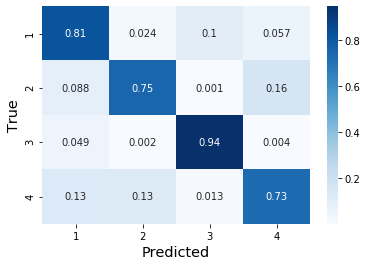

In [28]:
# Verification step 
Med_test_proj = pca.transform(med_test)
Med_Predicted_labels = classifier.predict(Med_test_proj)
# Test the predictions by making a correlation matrix
matrix_conf = confusion_matrix(Med_Labels,Med_Predicted_labels)
# Normalize confusion matrix
matrix_conf = matrix_conf.astype('float64') 
norm_fac = np.sum(matrix_conf[:], axis=1)
for row in range(matrix_conf.shape[0]):
    matrix_conf[row,:] = np.round(matrix_conf[row,:]*(1/norm_fac[row]),3)
# Plot confusion matrix    
sns_plot = sns.heatmap(matrix_conf, annot=True, cmap='Blues')
sns_plot.set(xticklabels=np.arange(1,5))
sns_plot.set(yticklabels=np.arange(1,5))
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
sns_fig = sns_plot.get_figure()
sns_fig.savefig(output_dir+'/ConfMat_StN150onStN50.png')

## Testing Against StN=300

In [35]:
pca = pickle.load(open(output_dir+'/PCA_StN150.class','rb'))
classifier = pickle.load(open(output_dir+'/ML_pred_StN150.class','rb'))
data_dir = '/export/carterrhea/Documents/Pumpkin/SpectraML/PCA_ML/Low'
syn_name = 'spec_'  # Prefix for synthetic data
syn_num = 40000  # Number of synthetic data
syn_ext = '.fits'  # Extension for synthetic data
n_components = 25  # Number of components we are interested in picking out using PCA
# Change Directories
os.chdir(data_dir)
# Read in Spectral Data using astropy
chan_min = 0  # Minimum value for channel
chan_max = 600  # Maximum value for channel
high_test = []
ct = 0
for spec_ct in tqdm(list(range(syn_num))):
    if ct%100 == 0:  # Only read in every 100 spectra
        spec = fits.open(syn_name+str(spec_ct)+syn_ext)
        spec = spec[1].data
        vals = list(spec[chan_min:chan_max][:])
        channel = list(list(zip(*vals))[0])
        counts = list(list(zip(*vals))[1])
        # Normalize Data
        counts_max = np.max(counts)
        counts_norm = [count/counts_max for count in counts]
        high_test.append(counts_norm)
    ct += 1




/home/carterrhea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [36]:
# Read in labels
High_Labels = []
ct = 0
with open('/export/carterrhea/Documents/Pumpkin/SpectraML/PCA_ML/low_tracking.txt','r') as f_lab:
    # Step through each line -> spectra
    next(f_lab)
    ct = 0
    for line in f_lab:
        if ct%100 == 0:  # Only read in every 100 spectra
            column = line.split(' ')
            # Label single vs double
            if column[-1].strip('\n') == 'single':  # single 
                High_Labels.append('single')
            elif column[-1].strip('\n') == 'double':
                High_Labels.append('double')
            elif column[-1].strip('\n') == 'triple':
                High_Labels.append('triple')
            elif column[-1].strip('\n') == 'quad':
                High_Labels.append('quad')    
        ct += 1        

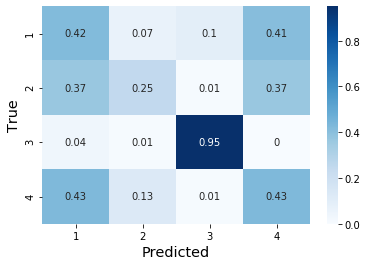

In [37]:
# Verification step 
High_test_proj = pca.transform(high_test)
High_Predicted_labels = classifier.predict(High_test_proj)
# Test the predictions by making a correlation matrix
matrix_conf = confusion_matrix(High_Labels,High_Predicted_labels)
# Normalize confusion matrix
matrix_conf = matrix_conf.astype('float64') 
norm_fac = np.sum(matrix_conf[:], axis=1)
for row in range(matrix_conf.shape[0]):
    matrix_conf[row,:] = np.round(matrix_conf[row,:]*(1/norm_fac[row]),3)
# Plot confusion matrix    
sns_plot = sns.heatmap(matrix_conf, annot=True, cmap='Blues')
sns_plot.set(xticklabels=np.arange(1,5))
sns_plot.set(yticklabels=np.arange(1,5))
plt.ylabel('True', fontsize='x-large')
plt.xlabel('Predicted', fontsize='x-large')
sns_fig = sns_plot.get_figure()
sns_fig.savefig(output_dir+'/ConfMat_StN150onStN300.png')

# What if we have five underlying Components?

In [38]:
data_dir = '/export/carterrhea/Documents/Pumpkin/PCA/StN150_Pent'
syn_name = 'sim_data_quad_'  # Prefix for synthetic data
syn_num = 100  # Number of synthetic data
syn_ext = '.fits'  # Extension for synthetic data
n_components = 25  # Number of components we are interested in picking out using PCA
# Change Directories
os.chdir(data_dir)
# Read in Spectral Data using astropy
chan_min = 0  # Minimum value for channel
chan_max = 600  # Maximum value for channel
low_test = []
ct = 0
for spec_ct in tqdm(list(range(syn_num))):
        spec = fits.open(syn_name+str(spec_ct)+syn_ext)
        spec = spec[1].data
        vals = list(spec[chan_min:chan_max][:])
        channel = list(list(zip(*vals))[0])
        counts = list(list(zip(*vals))[1])
        # Normalize Data
        counts_max = np.max(counts)
        counts_norm = [count/counts_max for count in counts]
        low_test.append(counts_norm)
Labels = ['pent' for i in range(syn_num)] 

# Set up classifier and PCA models
pca_apec = pickle.load(open(output_dir+'/PCA_StN150.class','rb'))
classifier_apec = pickle.load(open(output_dir+'/ML_pred_StN150.class','rb'))
Low_test_proj = pca_apec.transform(low_test)
Low_Predicted_labels = classifier_apec.predict(Low_test_proj)

c = collections.Counter(Low_Predicted_labels)
c = sorted(c.items())
months_num = [i[0] for i in c]
freq = [i[1] for i in c]

plt.bar(months_num, freq)
plt.savefig(output_dir+'/150_pent.png')

FileNotFoundError: [Errno 2] No such file or directory: '/export/carterrhea/Documents/Pumpkin/PCA/StN150_Pent'